In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Dropout, Input
import keras
from keras.callbacks import *
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from scipy.stats import pearsonr

In [2]:
# Importando dados
data = pd.read_excel(r'Conjunto de Dados Completo Original.xlsx')
data = data[['Chuva_observada (mm)', 'Chuva_Acum (mm)', 'ENA_Grande (MWmed)']]

In [3]:
# Definindo parâmetros
sequence_length = 12
batch_size = 32
stride = 1
learning_rate = 0.01
train_cut = int(0.7*len(data))

# Escalonando todos os dados para o intervalo entre 0 e 1
scaler = MinMaxScaler()
scaler.fit(data[:train_cut])
data_scaled = scaler.transform(data)

scaler_Y = MinMaxScaler()
scaler_Y.fit(data[['ENA_Grande (MWmed)']][:train_cut])

# Convertendo o array numpy de volta para um DataFrame
data_scaled_df = pd.DataFrame(data_scaled, columns=data.columns)

# Separando inputs e targets
inputs = data_scaled_df[['Chuva_Acum (mm)', 'ENA_Grande (MWmed)']]
inputs = inputs.iloc[:-sequence_length]
targets = data_scaled_df.loc[sequence_length:, 'ENA_Grande (MWmed)']


# Criando o dataset
full_dataset = timeseries_dataset_from_array(
    inputs,
    targets,
    sequence_length=sequence_length,
    batch_size=batch_size,
    shuffle=False
)

# Converte o dataset em listas de arrays para divisão
inputs_list = []
targets_list = []

for batch in full_dataset:
    inputs, targets = batch
    inputs_list.extend(inputs.numpy())
    targets_list.extend(targets.numpy())

# Converte listas para arrays
inputs_array = np.array(inputs_list)
targets_array = np.array(targets_list)

# Divide os dados em treinamento, validação e teste (70%, 20%, 10%)
train_size = int(0.7 * len(inputs_array))
val_size = int(0.2 * len(inputs_array))
test_size = len(inputs_array) - train_size - val_size

x_train = inputs_array[:train_size]
y_train = targets_array[:train_size]

x_val = inputs_array[train_size:train_size + val_size]
y_val = targets_array[train_size:train_size + val_size]

x_test = inputs_array[train_size + val_size:]
y_test = targets_array[train_size + val_size:]

# Cria datasets de treinamento, validação e teste
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)


In [4]:
# Verificando os formatos de inputs e targets
for batch in train_dataset.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape) 

Input shape: (32, 12, 2)
Target shape: (32,)


In [5]:
# Definindo a arquitetura do modelo
model = Sequential()
model.add(Input(shape=(inputs.shape[1], inputs.shape[2])))
model.add(LSTM(units=12, return_sequences=True))
model.add(LSTM(units=12))
model.add(Dense(1))

In [6]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 12)         │           720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 12)             │         1,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,933 (7.55 KB)

 Trainable params: 1,933 (7.55 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Definindo callbacks
earlyStopping = EarlyStopping(monitor='val_loss', verbose=0, patience=20)
mcp_save = ModelCheckpoint('trained_models/LSTM.keras', save_best_only=True, monitor='val_loss')

# Treinando o modelo
history = model.fit(
    train_dataset,
    epochs=2000,
    validation_data=val_dataset,
    callbacks=[earlyStopping, mcp_save],
)

Epoch 1/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - loss: 0.0452 - val_loss: 0.0388
Epoch 2/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0307 - val_loss: 0.0496
Epoch 3/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0364 - val_loss: 0.0424
Epoch 4/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0316 - val_loss: 0.0359
Epoch 5/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0293 - val_loss: 0.0350
Epoch 6/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0284 - val_loss: 0.0361
Epoch 7/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0284 - val_loss: 0.0380
Epoch 8/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0294 - val_loss: 0.0371
Epoch 9/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0289 - val_loss: 0.0345
Epoch 10/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0275 - val_loss: 0.0326
Epoch 11/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0265 - val_loss: 0.0318
Epoch 12/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0258 

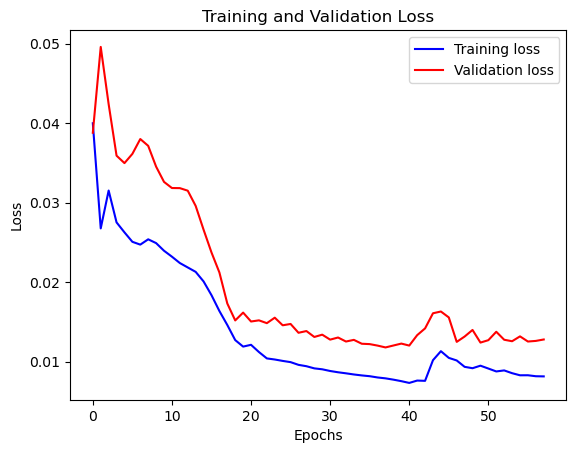

In [8]:
# Gráfico das curvas de custo do treinamento e validação
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


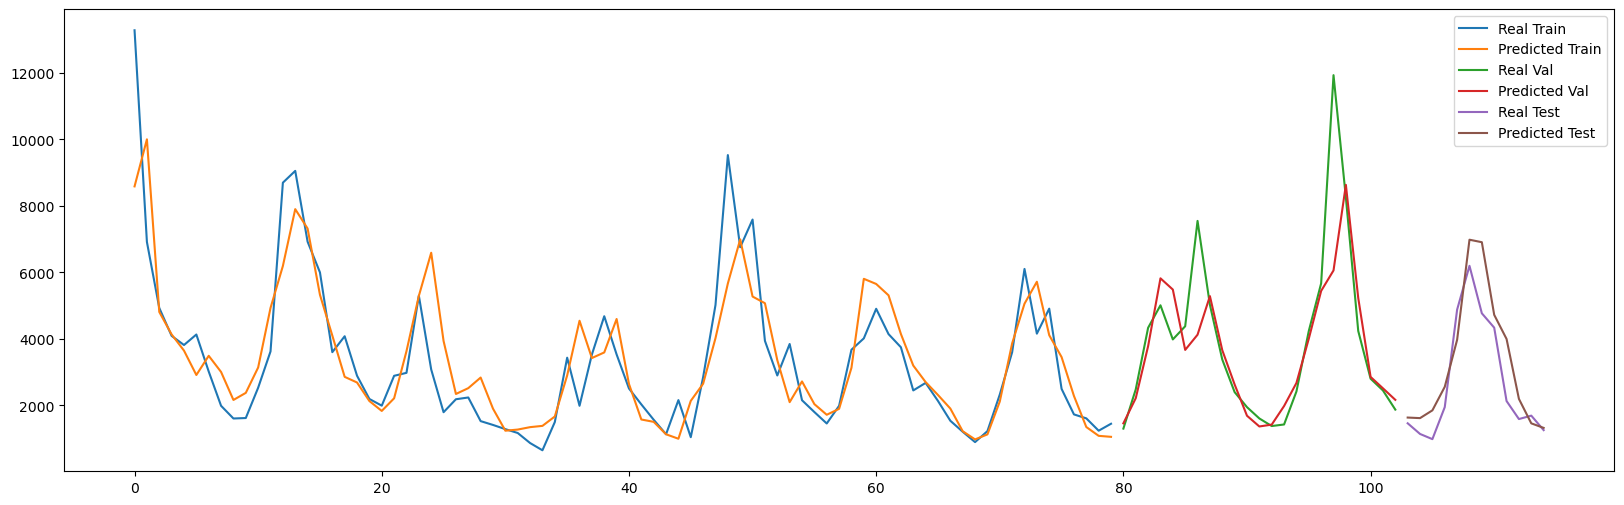

In [9]:
# carrega melhor modelo
from tensorflow.keras.models import load_model
model = load_model('trained_models/LSTM.keras',compile=False)

# Faz previsões
train_predict = model.predict(x_train)
val_predict = model.predict(x_val)
test_predict = model.predict(x_test)

# inverso das previsões
train_predict_inv = scaler_Y.inverse_transform(train_predict.reshape(-1, 1))
val_predict_inv = scaler_Y.inverse_transform(val_predict.reshape(-1, 1))
test_predict_inv = scaler_Y.inverse_transform(test_predict.reshape(-1, 1))

# Inverso dos valores reais
train_real_inv = scaler_Y.inverse_transform(y_train.reshape(-1, 1))
val_real_inv = scaler_Y.inverse_transform(y_val.reshape(-1, 1))
test_real_inv = scaler_Y.inverse_transform(y_test.reshape(-1, 1))

# Plota os resultados
plt.figure(figsize=(20,6))
plt.plot(train_real_inv.flatten(), label='Real Train')
plt.plot(train_predict_inv.flatten(), label='Predicted Train')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), val_real_inv.flatten(), label='Real Val')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), val_predict_inv.flatten(), label='Predicted Val')
plt.plot(np.arange(len(y_train) + len(y_val), len(y_train) + len(y_val) + len(y_test)), test_real_inv.flatten(), label='Real Test')
plt.plot(np.arange(len(y_train) + len(y_val), len(y_train) + len(y_val) + len(y_test)), test_predict_inv.flatten(), label='Predicted Test')
plt.legend()
plt.show()

In [10]:
# Função para calcular as métricas
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    correlation, _ = pearsonr(y_true, y_pred)
    return mae, rmse, mape, r2, correlation

# Calcula métricas para o conjunto de treinamento
train_mae, train_rmse, train_mape, train_r2, train_correlation = calculate_metrics(train_real_inv[1:].flatten(), train_predict_inv[1:].flatten())

# Calcula métricas para o conjunto de validação
val_mae, val_rmse, val_mape, val_r2, val_correlation = calculate_metrics(val_real_inv[1:].flatten(), val_predict_inv[1:].flatten())

In [11]:
# Imprime os resultados
print("Modelo LSTM:")
print(f"Conjunto de treinamento: MAE = {train_mae}, RMSE = {train_rmse}, MAPE = {train_mape}, R^2 = {train_r2}, Correlation = {train_correlation}")
print(f"Conjunto de validação: MAE = {val_mae}, RMSE = {val_rmse}, MAPE = {val_mape}, R^2 = {val_r2}, Correlation = {val_correlation}")
#print(f"Conjunto de teste: MAE = {test_mae}, RMSE = {test_rmse}, MAPE = {test_mape}, R^2 = {test_r2}, Correlation = {test_correlation}")

Modelo LSTM:
Conjunto de treinamento: MAE = 755.9206944719145, RMSE = 1104.4418325484487, MAPE = 26.261648574242326, R^2 = 0.682547980513506, Correlation = 0.8348348701337656
Conjunto de validação: MAE = 795.706953568892, RMSE = 1537.9158167115272, MAPE = 15.894892038006075, R^2 = 0.6239453479425099, Correlation = 0.8014117607540812
